# **Install Dependencies and Setup**

In [ ]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib

In [ ]:
!pip list

In [3]:
import tensorflow as tf 
import os 

In [4]:
#setting path in colab
#mount the drive first
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

#click on the URL and copy the code. paste it in the box and press enter




Mounted at /content/drive


In [5]:
#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "Colab Notebooks/Image Classification/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  #!touch 'new_file_test.txt'
  #print('working directory' + root_dir + project_folder + \
        #"empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

In [6]:
os.listdir(root_dir + project_folder)


['Data', 'Image_Classification.ipynb', 'logs']

In [7]:
from tensorflow.tools.docs.doc_controls import T
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# **Remove dodgy images**

In [8]:
import cv2 
import imghdr


In [9]:
data_dir = os.path.join(root_dir + project_folder + 'Data')

In [10]:
image_extensions = ['jpeg','jpg','bmp','png']

In [11]:
for image_class in os.listdir(data_dir): # will show happy and sad 
  for image in os.listdir(os.path.join(data_dir,image_class)): #loop through every image in happy and sad directory
    image_path = os.path.join(data_dir, image_class, image)
    try:
       img = cv2.imread(image_path)
       tip = imghdr.what(image_path)
       if tip not in image_extensions: 
         print('image not in extension list {}'.format(image_path))
         os.remove(image_path)
    except Exception as e: 
      print('Issue with image {}'.format(image_path))


# **LOAD DATA**

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
#tf.keras.utils.image_dataset_from_directory??

In [14]:
data = tf.keras.utils.image_dataset_from_directory('Data') # Building data pipeline

Found 189 files belonging to 2 classes.


In [15]:
#we can not loop through the data cuz it's uniteratable 
data_iterator = data.as_numpy_iterator() #allowing us to access our data pipeline

In [16]:
#get another batch from the iterator
batch = data_iterator.next() #accessing our data pipeline, grabing one batch. Batch has two parts, [0] our images and [1] is image's classes. 

In [17]:
#Images represented as numpy arrays 
batch[0].shape

(32, 256, 256, 3)

In [18]:
#Class one = sad people
#Class Zero = happy People 
batch[1]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1], dtype=int32)

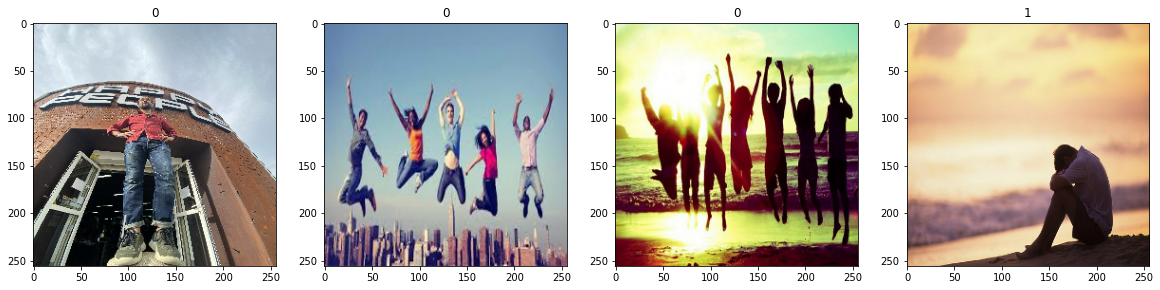

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# **Pre-processing Data**





Reduces the number of parameters, it's very much dependent on the dataset. If color is likely an important determinant of a class then no grayscale!

In [20]:
scaled_data = data.map(lambda x,y: (x/255, y))

In [21]:
scaled_batch = scaled_data.as_numpy_iterator().next()

In [22]:
scaled_batch[0].max()

1.0

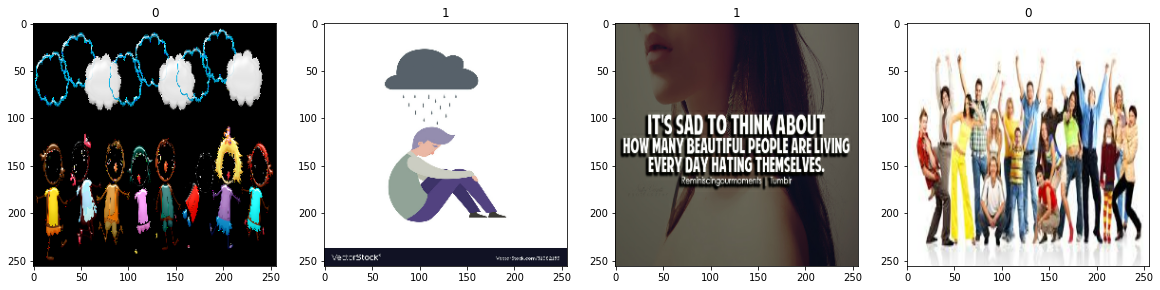

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(scaled_batch[1][idx])

# **Split Data**

In [24]:
len(scaled_data)

6

In [25]:
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)
test_size = int(len(scaled_data)*.1)+1

In [26]:
train_size + val_size + test_size

6

In [27]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

In [28]:
len(test)

1

# **Deep Learning Architecture**

**Building Model**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [30]:
model = Sequential() #sequential is used when u only have one input and one output

In [31]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu' ))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryFocalCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()])
#model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

**Training Model**

In [34]:
logdir = os.path.join(root_dir + project_folder +'logs')

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 6s 981ms/step - loss: 0.0600 - binary_accuracy: 0.9062 - false_negatives: 5.0000 - val_loss: 0.1061 - val_binary_accuracy: 0.8438 - val_false_negatives: 4.0000
Epoch 2/20
4/4 [==============================] - 5s 916ms/step - loss: 0.0605 - binary_accuracy: 0.8906 - false_negatives: 12.0000 - val_loss: 0.0425 - val_binary_accuracy: 0.9688 - val_false_negatives: 1.0000
Epoch 3/20
4/4 [==============================] - 4s 706ms/step - loss: 0.0496 - binary_accuracy: 0.9766 - false_negatives: 1.0000 - val_loss: 0.0258 - val_binary_accuracy: 1.0000 - val_false_negatives: 0.0000e+00
Epoch 4/20
4/4 [==============================] - 4s 708ms/step - loss: 0.0415 - binary_accuracy: 0.9375 - false_negatives: 6.0000 - val_loss: 0.0304 - val_binary_accuracy: 1.0000 - val_false_negatives: 0.0000e+00
Epoch 5/20
4/4 [==============================] - 5s 916ms/step - loss: 0.0292 - binary_accuracy: 0.9688 - false_negatives: 1.0000 - val_loss: 0.0101 -

**Plot Performance**

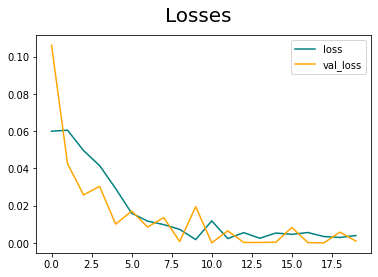

In [46]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Losses', fontsize=20)
plt.legend(loc="upper right")
plt.show()

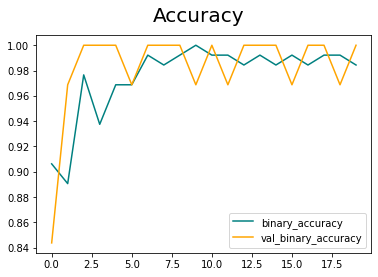

In [59]:
fig = plt.figure()
plt.plot(hist.history['binary_accuracy'], color='teal', label='binary_accuracy')
plt.plot(hist.history['val_binary_accuracy'], color='orange', label='val_binary_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

# **Performance Evaluation**

**Evaluate**

In [60]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [62]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [63]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

In [65]:
print(f'precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

precision:1.0, Recall:1.0, Accuracy:1.0


**Test**

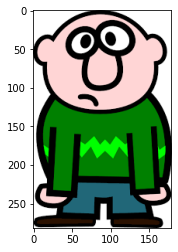

In [89]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

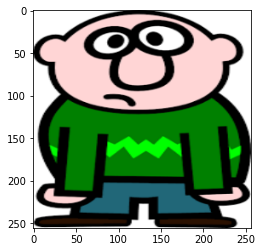

In [88]:
#to pass images to our neural network, our image has to be 256 x 256 and has 3 channels
img_resized = tf.image.resize((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),(256,256))
plt.imshow(img_resized.numpy().astype(int))
plt.show()

In [90]:
img_resized.shape

TensorShape([256, 256, 3])

In [91]:
np.expand_dims(img_resized, 0).shape

(1, 256, 256, 3)

In [92]:
happy_or_sad = model.predict(np.expand_dims(img_resized/255, 0))

In [93]:
happy_or_sad

array([[0.8819597]], dtype=float32)

In [94]:
if happy_or_sad > 0.5:
  print('Your model predicted the image as sad.')
else:
  print('Your model predicted the image as happy.')

Your model predicted the image as sad.


# **Save the Model for Future Use**

In [96]:
from tensorflow.keras.models import load_model 

In [98]:
model.save(os.path.join('models','imageclassificationmodel_happysad.h5'))

**Loading a model**

In [101]:
new_model = load_model(os.path.join('models', 'imageclassificationmodel_happysad.h5'))